In [9]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def show_image(path):
    img = Image.open(path)
    img_arr = np.array(img)
    plt.figure(figsize=(5,5))
    plt.imshow(np.transpose(img_arr, (0, 1, 2)))

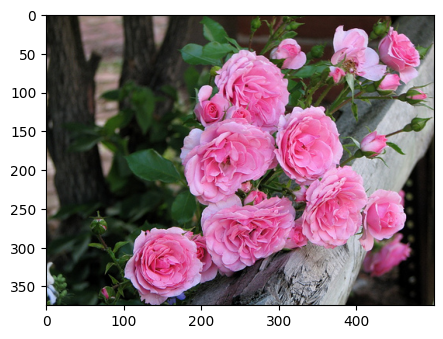

In [10]:
show_image("flowers/rose/537207677_f96a0507bb.jpg")

In [11]:
import torchvision.datasets as datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

# 对图片进行预处理 : resize、转换成tensor、标准化
transformations = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 将数据集放在Dataloader里，方便后面使用
total_dataset = datasets.ImageFolder("flowers", transform = transformations)
dataset_loader = DataLoader(dataset = total_dataset, batch_size = 100)
items = iter(dataset_loader)
image, label = items.next()

In [12]:
total_dataset.class_to_idx

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [13]:
def show_transformed_image(image):
    np_image = image.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


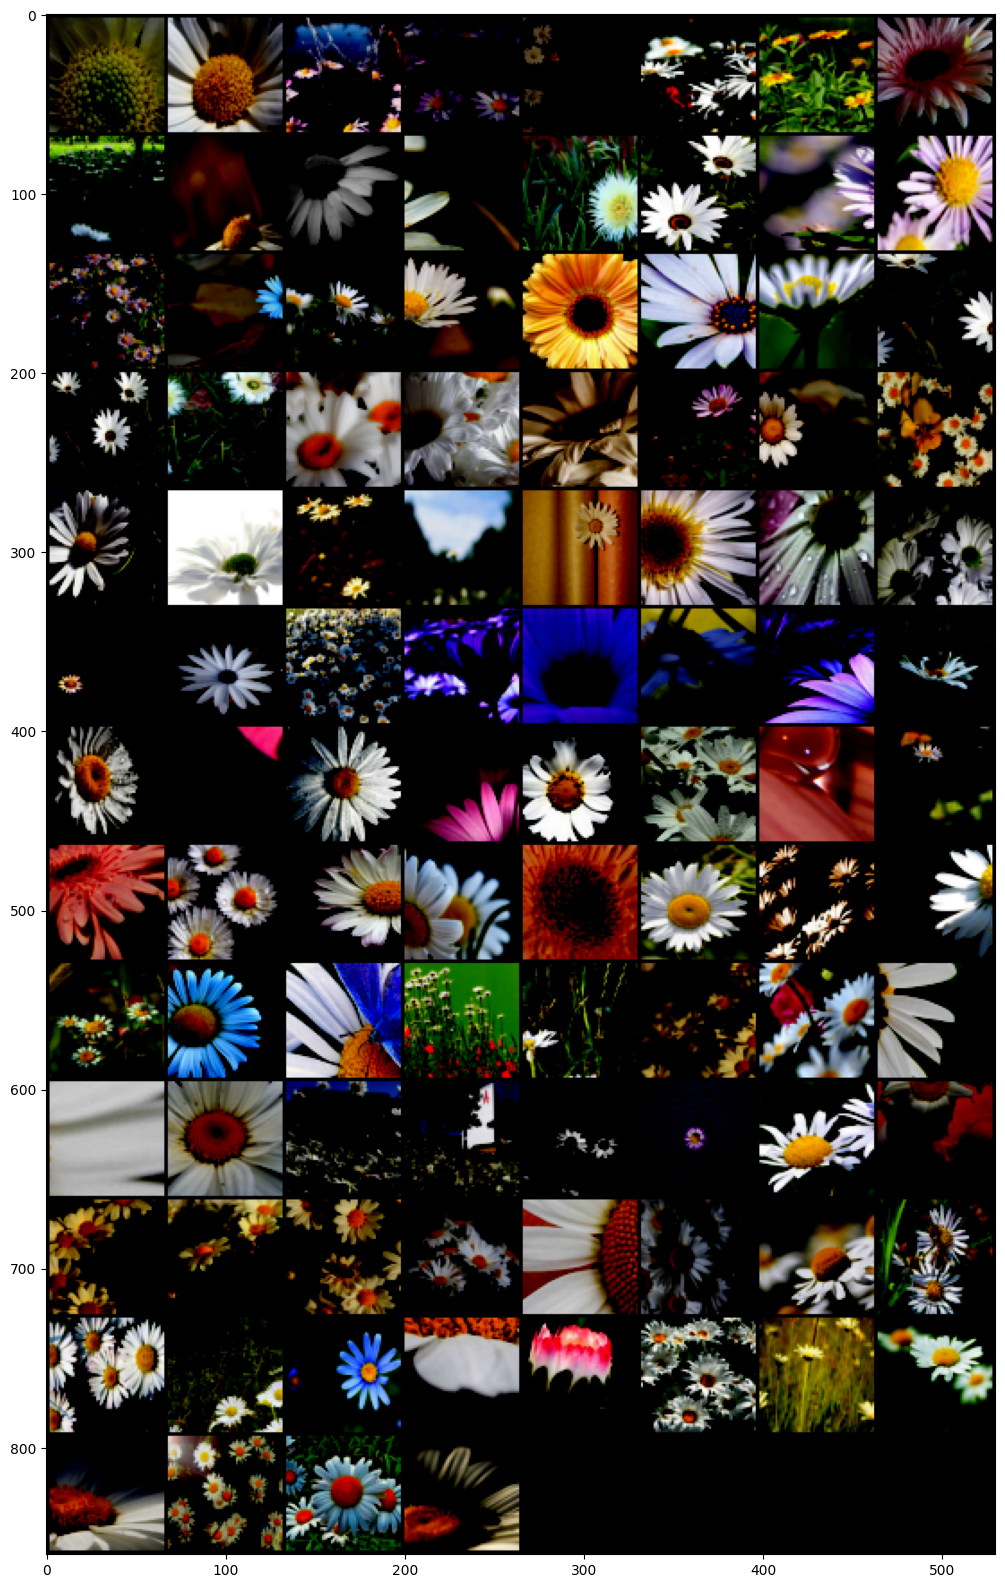

In [14]:
show_transformed_image(make_grid(image))

In [15]:
from torch.utils.data import random_split

# 随机切分数据集和测试集 4:1
train_size = int(0.8 * len(total_dataset))
test_size = len(total_dataset) - train_size
train_dataset, test_dataset = random_split(total_dataset, [train_size, test_size])

train_dataset_loader = DataLoader(dataset = train_dataset, batch_size = 100)
test_dataset_loader = DataLoader(dataset = test_dataset, batch_size = 100)

In [16]:
import torch.nn as nn

class FlowerClassifierCNNModel(nn.Module):
    
    def __init__(self, num_classes=5):
        super(FlowerClassifierCNNModel,self).__init__()
        
        # 卷积层
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3,stride=1, padding=1)
        # ReLU 激活函数
        self.relu1 = nn.ReLU()
        # 池化层
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        # 卷积层
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        # ReLU 激活函数
        self.relu2 = nn.ReLU()
        # 线性层
        self.lf = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)
    
    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        
        output = self.maxpool1(output)
        
        output = self.conv2(output)
        output = self.relu2(output)
        
        output = output.view(-1, 32 * 32 * 24)

        output = self.lf(output)

        return output

In [17]:
from torch.optim import Adam

cnn_model = FlowerClassifierCNNModel()
best_cnn_model = FlowerClassifierCNNModel()
optimizer = Adam(cnn_model.parameters())
# 交叉熵损失函数
loss_fn = nn.CrossEntropyLoss()
Train_Acc=[]
Test_Acc=[]

In [18]:
def TrainAcc(model):
    model.eval()
    train_acc_count=0
    for k,(train_images,train_labels) in enumerate(train_dataset_loader):
        train_outputs=model(train_images)
        _,prediction=torch.max(train_outputs.data,1)
        train_acc_count+=torch.sum(prediction==train_labels.data).item()
    train_accuracy = train_acc_count/len(train_dataset)
    return train_accuracy

In [19]:
def TestAcc(model):
    model.eval()
    test_acc_count = 0
    for k, (test_images, test_labels) in enumerate(test_dataset_loader):
        test_outputs = cnn_model(test_images)
        _, prediction = torch.max(test_outputs.data, 1)
        test_acc_count += torch.sum(prediction == test_labels.data).item()
    test_accuracy = test_acc_count / len(test_dataset)
    return test_accuracy

In [18]:
import torch
def train_and_build(n_epoches):
    Best_test_acc=0
    print("开始训练")
    for epoch in range(n_epoches):
        print("epoch:",epoch)
        cnn_model.train()
        for i, (images, labels) in enumerate(train_dataset_loader):
            optimizer.zero_grad()
            outputs = cnn_model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
        train_acc= TrainAcc(cnn_model)
        test_acc = TestAcc(cnn_model)
        print(" train Acc:",train_acc,"  Test Acc:",test_acc)
        Train_Acc.append(train_acc)
        Test_Acc.append(test_acc)
        if(Best_test_acc<TestAcc(cnn_model)):
            Best_test_acc=TestAcc(cnn_model)
            best_cnn_model=cnn_model

In [ ]:
train_and_build(200)

开始训练
epoch: 0
 train Acc: 0.542353281295172   Test Acc: 0.5271676300578034
epoch: 1
 train Acc: 0.5521827117664064   Test Acc: 0.5317919075144508
epoch: 2
 train Acc: 0.5701069673315987   Test Acc: 0.5676300578034682
epoch: 3
 train Acc: 0.6039317721884938   Test Acc: 0.5838150289017341
epoch: 4
 train Acc: 0.5998843596415149   Test Acc: 0.6057803468208093
epoch: 5
 train Acc: 0.6238797340271754   Test Acc: 0.6277456647398844
epoch: 6
 train Acc: 0.6282162474703672   Test Acc: 0.638150289017341
epoch: 7
 train Acc: 0.6276380456779416   Test Acc: 0.6277456647398844
epoch: 8
 train Acc: 0.6392020815264527   Test Acc: 0.6335260115606937
epoch: 9
 train Acc: 0.6513443191673894   Test Acc: 0.6404624277456648
epoch: 10
 train Acc: 0.63370916449841   Test Acc: 0.6601156069364161
epoch: 11
 train Acc: 0.6617519514310495   Test Acc: 0.6473988439306358
epoch: 12
 train Acc: 0.6657993639780283   Test Acc: 0.653179190751445
epoch: 13
 train Acc: 0.6522116218560278   Test Acc: 0.6462427745664739
ep

In [23]:
TestAcc(best_cnn_model)

0.7294797687861272

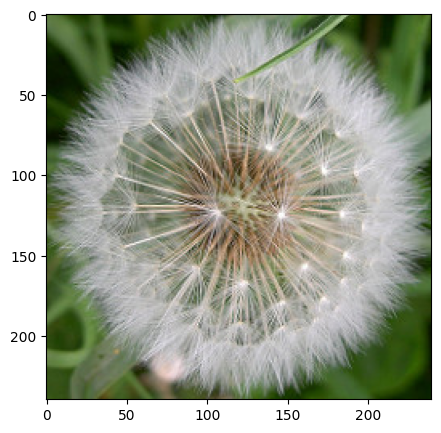

In [24]:
show_image("flowers/dandelion/13920113_f03e867ea7_m.jpg")

In [28]:
test_image = Image.open("flowers/dandelion/13920113_f03e867ea7_m.jpg")
test_image_tensor = transformations(test_image).float()
test_image_tensor = test_image_tensor.unsqueeze_(0)
output = best_cnn_model(test_image_tensor)
class_index = output.data.numpy().argmax()

In [ ]:
print(class_index)

In [35]:
#保存整个模型
PATH="models"
torch.save(best_cnn_model, 'CnnModel.pth')

#读取模型
#model = torch.load('CnnModel.pth')

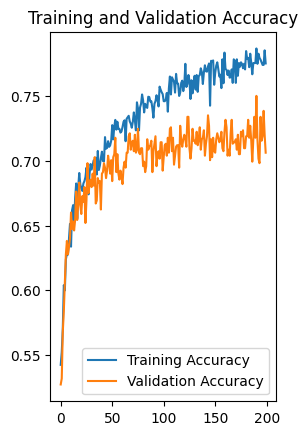

In [38]:
#要补训练准确率变化情况和测试准确率变化情况
#打印训练误差图像
from matplotlib import pyplot as plt
np.set_printoptions(threshold=np.inf)
plt.subplot(1, 2, 1)
plt.plot(Train_Acc, label='Training Accuracy')
plt.plot(Test_Acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()